## Crop Classification with CNNs

Dataset contains 30 different types of crop images in separate folders

Although the dataset is very well curated and preprocessed, it still pose a challenge since the number of categories is fairly elevated (30) and we only have around 800 images to work with

The challenge will be to create a model usign only CNNs, no transfer learning nor heavy back bones, and try to get the highest accuracy possible.

### TODO: Hacer un indice

0. Load the data

In [54]:
import tensorflow as tf
import os

tf.random.set_seed(314)

# Define multiple file patterns
file_patterns = [
    "Agricultural-crops/*/*.jpeg",
    "Agricultural-crops/*/*.png",
    "Agricultural-crops/*/*.jpg",
]

# Create a dataset for each file pattern
datasets = [tf.data.Dataset.list_files(pattern) for pattern in file_patterns]

# Concatenate the datasets
dataset = datasets[0]
for ds in datasets[1:]:
    dataset = dataset.concatenate(ds)

In [55]:
label_list = os.listdir('Agricultural-crops')
label_dict = {label: i for i, label in enumerate(label_list)}

keys = tf.constant(list(label_dict.keys()))
values = tf.constant(list(label_dict.values()))
name_to_index = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys, values),
    default_value=-1  # Return -1 if the label is not found
)

In [56]:
# Step 2: Define preprocessing function
img_sz = 244
def preprocess_image_and_label(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [img_sz, img_sz])
    image = image / 255.0  # Normalize

    parent_folder = tf.strings.split(file_path, os.sep)[-2]
    label = name_to_index.lookup(parent_folder)

    return image, label

# Step 3: Apply preprocessing
dataset = dataset.map(preprocess_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)

One interesting problem we had is that around 20 images in this dataset were in "webp" format, which is not supported by TensorFlow. 
  
But they were marked as jpg, which caused a great deal of confusion.


We had detect them using the imghdr library and then delete them with the following code:

1. Exploratory data analysis

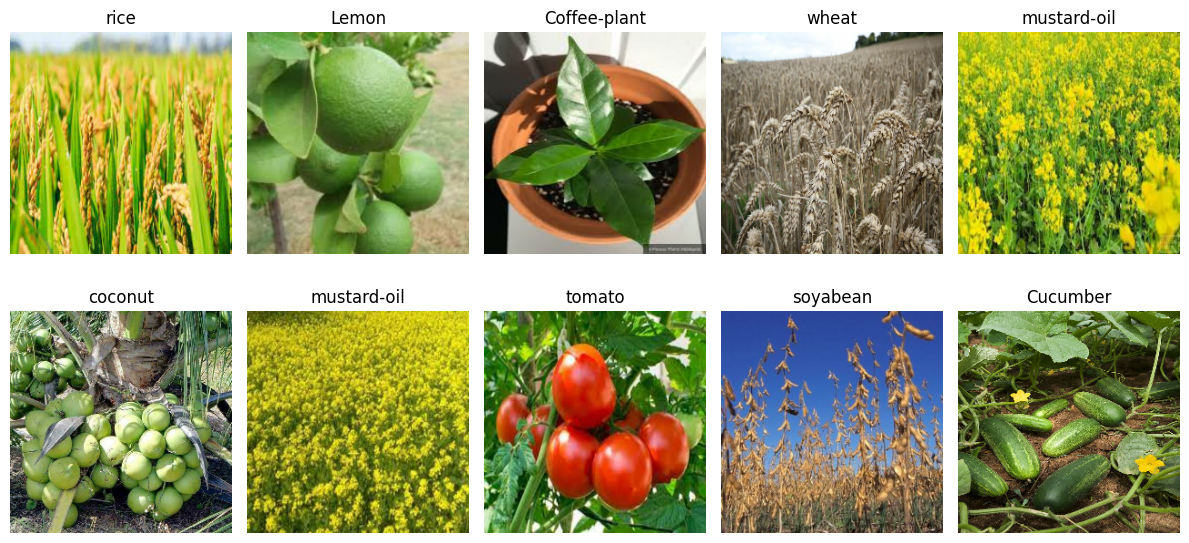

In [57]:
import matplotlib.pyplot as plt

# Take 10 random images from the dataset
random_data = dataset.take(10)

# Convert the images to numpy arrays
random_data = [(image.numpy(), label.numpy()) for image, label in random_data]


# Plot the images with labels
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, (image, label) in enumerate(random_data):
    axes[i].imshow(image)
    axes[i].set_title(label_list[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Looking at some examples we can see the our data presents a variety of agricultural crops. We can see that the images are of different sizes and shapes, so we will need to resize them to a common size.
Also, some images are taken from afar or are taken at an early stage of matturity, such as the cofee plant, which could make its classification difficult, but we will see how our model performs.

2. Dataloader

In [58]:
# we shuffle the dataset to ensure that the model does not overfit to the order of the images.
dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=False)

# Calculate the number of elements
# we will perform an 80/20 split with no validation dataset.
dataset_size = dataset.cardinality().numpy()
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into train and test
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [59]:
dataset_size

794

In [60]:
# batch, and prefetch
# this number comes from experimentation and depends on the available memory on your machine.
batch_size = 4

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [61]:
# We check that our dataset have the correct dimensions.
for X, y in train_dataset.take(1):
    print(X.shape, y.shape)

for X, y in test_dataset.take(1):
    print(X.shape, y.shape) 

(4, 244, 244, 3) (4,)
(4, 244, 244, 3) (4,)


3. Model training

In [62]:
def build_model(input_shape=(img_sz, img_sz, 3)):
        model = tf.keras.Sequential(
                layers=[tf.keras.layers.Input(shape=input_shape),

                                tf.keras.layers.BatchNormalization(renorm=True),
                                tf.keras.layers.Conv2D(64, 3, activation='relu', data_format="channels_last"),
                                tf.keras.layers.MaxPool2D(),

                                tf.keras.layers.BatchNormalization(renorm=True),
                                tf.keras.layers.Conv2D(128, 3, activation='relu', data_format="channels_last"),
                                tf.keras.layers.MaxPooling2D(),

                                tf.keras.layers.BatchNormalization(renorm=True),
                                tf.keras.layers.Conv2D(256, 3, activation='relu', data_format="channels_last"),
                                tf.keras.layers.Conv2D(256, 3, activation='relu', data_format="channels_last"),
                                tf.keras.layers.GlobalAvgPool2D(),

                                tf.keras.layers.Dense(30, activation='softmax'),
                           ]
                )
    
        model.build()
        model.summary()

        return model

In [63]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 244, 244, 3)      21        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 242, 242, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 121, 121, 64)     448       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 128)     73856     
                                                        

In [64]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [65]:
log_dir = "logs/" + "model08"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [66]:
epochs = 60
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[tensorboard_callback])

Epoch 1/60
159/159 [==============================] - 38s 216ms/step - loss: 3.4482 - accuracy: 0.0488 - val_loss: 3.1747 - val_accuracy: 0.1572
Epoch 2/60
159/159 [==============================] - 33s 203ms/step - loss: 3.3318 - accuracy: 0.0630 - val_loss: 2.9981 - val_accuracy: 0.1258
Epoch 3/60
159/159 [==============================] - 34s 209ms/step - loss: 3.1610 - accuracy: 0.0913 - val_loss: 2.9735 - val_accuracy: 0.1572
Epoch 4/60
159/159 [==============================] - 34s 209ms/step - loss: 3.0567 - accuracy: 0.1228 - val_loss: 2.8930 - val_accuracy: 0.1509
Epoch 5/60
159/159 [==============================] - 33s 203ms/step - loss: 2.9758 - accuracy: 0.1402 - val_loss: 2.7274 - val_accuracy: 0.1950
Epoch 6/60
159/159 [==============================] - 488s 3s/step - loss: 2.8332 - accuracy: 0.1732 - val_loss: 2.7036 - val_accuracy: 0.2201
Epoch 7/60
159/159 [==============================] - 33s 205ms/step - loss: 2.7573 - accuracy: 0.1984 - val_loss: 2.6532 - val_accu

In [67]:
# Step 4: Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

40/40 [==============================] - 2s 32ms/step - loss: 0.4505 - accuracy: 0.9371
Test Accuracy: 0.9371


### 4. Experimentation

In this section we will focus on the other experiments we did which yielded worse results than the previous one.


Every loss curve, for training set as well as for the validation set can be found in the tensorboard logs, which themselves can be rendered in a browser using the following command:

! tensorboard --logdir logs

For all models we used Conv2d layers with a number of filters which doubled with each new layer, a kernel size of 3, padding = 'same'. Our first layer have 64 filters, the second 128 and so on.

All models were trained for a 60 epochs.

1. model with 3 layers

| ![Example Image](imgs/3l.png) | We can observe that the model  |
|--------------------------------------------------|----------------------------------------------|



2. model with 4 layers

3. model with 5 layers

4. model with 5 layers 256 - 256

5. model with master arquitechture

In [68]:
from IPython.display import HTML

# HTML code for the table
table = """
<table>
  <tr>
    <td><img src="imgs/3l.png" alt="3 layered model"></td>
    <td>Accuracy reached 53%, which is decent for a model with 30 evenly distributed classes and a base random chance of 3%.<br>
      There seems to be no signs of overfitting, since train and test accuracies are close.</td>
  </tr>
  <tr>
    <td><img src="imgs/4l.png" alt="4 layered model"></td>
    <td>This is the second example image.</td>
  </tr>
  <tr>
    <td><img src="imgs/5l.png" alt="5 layered model"></td>
    <td>This is the second example image.</td>
  </tr>
  <tr>
    <td><img src="imgs/5l-256-256.png" alt="5 layered modified model"></td>
    <td>This is the second example image.</td>
  </tr>
  <tr>
    <td><img src="imgs/6l-imgsz_640.png" alt="6 layered model"></td>
    <td>This is the second example image.</td>
  </tr>
</table>
"""

# Display the HTML table
HTML(table)


,"Accuracy reached 53%, which is decent for a model with 30 evenly distributed classes and a base random chance of 3%. There seems to be no signs of overfitting, since train and test accuracies are close."
,This is the second example image.
,This is the second example image.
,This is the second example image.
,This is the second example image.


### 5. Conclusion


We will conclude with a likely explanation as to why our selected model performed better

### TODO: volver a correr mi arquitetura estrella pero solo con 60 epochs para no levantar sospechas.

TODO: obtain classs distribution.
TODO: obtain size dsitribution.